<a href="https://colab.research.google.com/github/Tensor10/GEEMAP/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISPRS Tutorial on Satellite Time Series

Authors:

[Dr. Marc Russwurm](https://www.marcrusswurm.com) [EPFL-ECEO](https://www.epfl.ch/labs/eceo/)
Prof. Charlotte Pelletier IRISA-Obelix

main tutorial page
https://dl4sits.github.io/isprs2022/tutorial/

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by.png" width=100px>

## Part 2: Deep Learning with Learned Features 

https://dl4sits.github.io/isprs2022/tutorial/

models and dataset available in the [BreizhCrops package](https://github.com/dl4sits/BreizhCrops)

<img src="https://i.ibb.co/q0rb1Pz/Notebook2.png" width=100%>

## Notebook Outline

1. Setup
2. Deep Learning Model
3. Optimization
4. (optional) Transferability

# 1 Setup


## 1.1 Installation of dependencies

In [ ]:
!pip install -q breizhcrops
# !pip install -q git+https://github.com/dl4sits/BreizhCrops.git # alternative install directly from github

import matplotlib.pyplot as plt
import torch

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.exposure import equalize_hist
import numpy as np

# plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.rc("axes.spines", top=False, right=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on {device}")

     |████████████████████████████████| 1.0 MB 8.0 MB/s 
     |████████████████████████████████| 16.7 MB 292 kB/s 
     |████████████████████████████████| 6.3 MB 13.7 MB/s 
running on cpu


## 1.2 The BreizhCrops Dataset

In this notebook, we use the BreizhCrops dataset for data loading and definition of deep learning model.

Source code and models are publically available at
https://github.com/dl4sits/BreizhCrops

with more information at https://www.breizhcrops.org

Functionality:
```
dataset = BreizhCrops(<region>, <data_transform_function>)
timeseries_X, label_y, field_id = dataset[<index>]
```

We use regions `kermaux` (same area as [Part 1 notebook](https://colab.research.google.com/drive/1ZJIJKvFefrrrlKgaWjUaq3_Kelnp9Wq5?usp=sharing)) and `belle-ile` (introduced later)


### The transforms function

The `<data_transform_function>` is applied to each time series sample and can be used for feature extraction (e.g. ndvi calculation).

Lets define a transforms function that only takes reflectance bands (no quality flags or day of year)

In [ ]:
# in the right order, as stored internally
allbands = ["B1",  # ultra-violett
            "B2",  # blue
            "B3",  # green
            "B4",  # red
            "B5",  # near-infrared
            "B6",  # near-infrared
            "B7",  # near-infrared
            "B8",  # near-infrared
            "B8A", # near-infrared 
            "B9",  # atmosphere
            "B10", # atmosphere
            "B11", # short-wave infrared
            "B12", # short-wave infrared
            'QA10', 
            'QA20', 
            'QA60', # quality flag (can be used for cloud detection)
            'doa' # day of year
            ]

# reflectance (in the right order for pre-trained models used later)
reflectance_bands = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 
                     'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']

# only the reflectance bands
reflectance_bands_idxs = [allbands.index(b) for b in 
                          reflectance_bands]

# return only reflectance bands (no QA and doa flags)
def transform(x):
  return x[:,reflectance_bands_idxs] * 1e-4 # rescale to from 0-10000 to 0-1

### Initialization and download

In [ ]:
import breizhcrops as bzh

# initialize class
ds = bzh.BreizhCrops("kermaux", transform=transform)

# get a sample
X,y,field_id = ds[0]

print(f"BreizhCrops Kermaux with {len(ds)} samples")
print(f"class ids: {ds.classes}")
print(f"class names: {ds.classname}")

classmapping.csv: 8.19kB [00:00, 16.0kB/s]
kermaux.csv: 8.19kB [00:00, 19.3kB/s]


downloading breizhcrops_dataset/2017/L1C/kermaux.h5.tar.gz


kermaux.h5.tar.gz: 901kB [00:00, 962kB/s]                            


extracting breizhcrops_dataset/2017/L1C/kermaux.h5.tar.gz to breizhcrops_dataset/2017/L1C/kermaux.h5
removing breizhcrops_dataset/2017/L1C/kermaux.h5.tar.gz
checking integrity by file size...
ok!


codes.csv: 24.6kB [00:00, 60.3kB/s]                            

BreizhCrops Kermaux with 73 samples
class ids: [0 1 2 3 4 5 6 7 8]
class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


### Data exploration

In [ ]:
# load geometries
field_parcels_geodataframe = ds.geodataframe()
field_parcels_geodataframe.head()

kermaux.tar.gz: 41.0kB [00:00, 72.7kB/s]                            


id CODE_CULTU                     path     meanCLD  sequencelength  \
0  6018570        BTH  csv/kermaux/6018570.csv  725.350415             102   
1  6018572        BTH  csv/kermaux/6018572.csv  716.213573             102   
2  6020773        MIS  csv/kermaux/6020773.csv  699.473829             102   
3  6020775        MIS  csv/kermaux/6020775.csv  695.937165             102   
4  6028789        RGA  csv/kermaux/6028789.csv  747.489433             102   

   classid          classname   region  \
0        1              wheat  kermaux   
1        1              wheat  kermaux   
2        3               corn  kermaux   
3        3               corn  kermaux   
4        8  temporary meadows  kermaux   

                                            geometry  
0  POLYGON ((258844.920 6780081.001, 258943.258 6...  
1  POLYGON ((258591.432 6780207.719, 258594.387 6...  
2  POLYGON ((258203.382 6780420.039, 258193.356 6...  
3  POLYGON ((257660.875 6780461.427, 257662.935 6...  
4  POLYGON ((257925.760 6782046.100, 257866.230 6...

In [ ]:

@interact(idx=widgets.IntSlider(min=0, max=len(ds), step=1, value=10))
def plot_timeseries(idx):

  X,y, field_id = ds[idx]

  fig, ax = plt.subplots(figsize=(12,3))
  _ = ax.plot(X, "o-")
  ax.set_xlabel("time [index]")
  ax.set_ylabel("reflectance")
  ax.set_title(f"field_id {field_id}; class id {y} ({ds.classname[y]})", fontsize=16)

  fig, ax = plt.subplots(figsize=(8,8))
  ax.axis("off")
  field_parcels_geodataframe.to_crs(epsg=3857).plot(ax=ax, color="lightblue")
  selected_field_geometry = field_parcels_geodataframe.to_crs(epsg=3857).loc[field_parcels_geodataframe.id==field_id]
  selected_field_geometry.plot(ax=ax, edgecolor="black", color="black")



interactive(children=(IntSlider(value=10, description='idx', max=73), Output()), _dom_classes=('widget-interac…

# 2 Deep Learning Model

Takeaway: Neural networks are flexible functions with trainable parameters:
* here, we define a neural network
* look into the weight tensors, play with convolutional kernels
* outline the conceptual components: feature extractor + classifier

### 1D CNN Model Definition


<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/modelschematic.png" width="100%" />



In [ ]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torch import nn
import torch

class Simple1DCNNModel(nn.Module):

  # constructor (called on when model = Simple1DCNNModel(n_inputs=13,n_classes=9))
  def __init__(self, n_inputs, n_classes, feature_dimension=64):
    super(Simple1DCNNModel, self).__init__()

    self.feature_extractor = nn.Sequential(
          nn.Conv1d(13, feature_dimension, kernel_size=5, padding=5),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=5),
          nn.Conv1d(feature_dimension, feature_dimension, kernel_size=5, padding=5),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=5),
          nn.Conv1d(feature_dimension, feature_dimension, kernel_size=5, padding=5),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=5),
      )
    self.classifier = nn.Linear(64, n_classes)

  # called when data is passed through the model: model(X)
  def forward(self, X):
    X = X.permute(0,2,1) # permute N x T x D -> N x D x T
    X = self.feature_extractor(X)
    X = X.mean(-1) # global average pooling
    X = self.classifier(X)
    return X
 

lets initialize a random model

In [ ]:
model = Simple1DCNNModel(n_inputs=13,n_classes=9)
model

Simple1DCNNModel(
  (feature_extractor): Sequential(
    (0): Conv1d(13, 64, kernel_size=(5,), stride=(1,), padding=(5,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(5,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(5,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=64, out_features=9, bias=True)
)

Number of Parameters

In [ ]:
print(f"{'layer':<32}: {'number of parameters'}")
print("".join(["-"]*48))
for name, parameter in model.named_parameters():
    print(f"{name:<32}: {np.prod(parameter.shape)}")
print("".join(["-"]*48))
print(f"{'total':<32}: {np.sum([np.prod(parameter.shape) for parameter in model.parameters()])}")

layer                           : number of parameters
------------------------------------------------
feature_extractor.0.weight      : 4160
feature_extractor.0.bias        : 64
feature_extractor.3.weight      : 20480
feature_extractor.3.bias        : 64
feature_extractor.6.weight      : 20480
feature_extractor.6.bias        : 64
classifier.weight               : 576
classifier.bias                 : 9
------------------------------------------------
total                           : 45897


## 2.1 Feature Extractor

In [ ]:
model.feature_extractor

Sequential(
  (0): Conv1d(13, 64, kernel_size=(5,), stride=(1,), padding=(5,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(5,))
  (4): ReLU()
  (5): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (6): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(5,))
  (7): ReLU()
  (8): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
)

1D Convolutional Layers

interactive convolution

try out some established kernels:
```
moving_average = (0.2,0.2,0.2,0.2,0.2)
gaussian = (0.35, 1.3, 2, 1.3, 0.35)
laplace = (0.1, 0.2, -1.6, 0.2, 0.1)
```

In [ ]:
#@title
weightcolor = "#00a79f"

field_idx = 0
band_idx = 2

X,y,fid = ds[field_idx]

@interact(w1=widgets.FloatSlider(value=0,min=-2.,max=2, step=0.05), 
          w2=widgets.FloatSlider(value=0.1,min=-2.,max=2, step=0.05),
          w3=widgets.FloatSlider(value=0.5,min=-2.,max=2, step=0.05),
          w4=widgets.FloatSlider(value=0.1,min=-2.,max=2, step=0.05),
          w5=widgets.FloatSlider(value=0,min=-2.,max=2, step=0.05))
def plot_convolution(w1,w2,w3,w4,w5):
  weights = np.array([w1,w2,w3,w4,w5])


  convolved_signal = np.convolve(X[:,2], weights)[2:-2]

  fig, axs = plt.subplots(1,3, figsize=(16,4))

  ax = axs[0]
  ax.set_title("signal")
  ax.plot(X[:,band_idx])
  ax.set_xlabel("time [index]")

  ax = axs[1]
  ax.set_title("weight")
  ax.plot(np.arange(5), weights,"o-", color=weightcolor)
  ax.bar(np.arange(5), weights, alpha=0.2, color=weightcolor)
  ax.set_xticks([0,1,2,3,4])
  ax.set_xticklabels(["w1","w2","w3","w4","w5"])

  ax = axs[2]
  ax.set_title(r"signal $\ast$ weight")
  ax.plot(convolved_signal)
  ax.set_xlabel("time [index]")


interactive(children=(FloatSlider(value=0.0, description='w1', max=2.0, min=-2.0, step=0.05), FloatSlider(valu…



The feature extractor is build on 1D-Convolutional layers

Let's take the first layer that transforms 13 input channels into 64 hidden dimensions for each time instance

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/convschematic.png" width=600px>

In [ ]:
first_conv1d = model.feature_extractor[0]
print(first_conv1d)

weight = model.feature_extractor[0].weight
print()
print(f"weight: [outfeatures x inchannels x kernelsize]: {weight.shape}")

Conv1d(13, 64, kernel_size=(5,), stride=(1,), padding=(5,))

weight: [outfeatures x inchannels x kernelsize]: torch.Size([64, 13, 5])


In [ ]:
model = model.cpu()

@interact(inchannel=np.arange(weight.shape[1]), outfeature=np.arange(weight.shape[0]))
def plot_convolutional_filter(inchannel, outfeature):
  fig, ax = plt.subplots()
  ax.plot(np.arange(5), first_conv1d.weight[outfeature,inchannel].detach().numpy(), "o-", color=weightcolor)
  ax.bar(np.arange(5), first_conv1d.weight[outfeature,inchannel].detach().numpy(), alpha=0.2, color=weightcolor)
  ax.set_title(f"maps {reflectance_bands[inchannel]} to feature {outfeature}")
  ax.set_xlabel("kernel")

interactive(children=(Dropdown(description='inchannel', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), va…

The Feature extractor


<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/feature_extractor.png" width=800px>

In [ ]:
#@title
field_index = 0

@interact(field_index=widgets.IntSlider(value=0,min=0.,max=len(ds)),
          t_max=widgets.IntSlider(value=102,min=64.,max=102))
def plot_features(field_index, t_max):

  X,y,field_id = ds[field_index]

  X = torch.from_numpy(X).float().permute(1,0)

  X = X[:, :t_max]

  # make a batch of a single sample [1 x 13 x 102]
  batch = X.unsqueeze(0)

  features = model.feature_extractor(X)
  features = features.mean(-1) # average pooling over the time dimension

  fig, axs = plt.subplots(1,2, figsize=(16,3))

  ax = axs[0]
  ax.plot(X.T)
  ax.set_xlabel("time [index]")
  ax.set_ylabel("input reflectance")
  ax.set_title("input time series (variable length)")
  ax.set_xlim(0,102)

  ax = axs[1]
  ax.barh(np.arange(features.shape[0]), features.detach().numpy())
  ax.set_ylabel("feature dimension")
  ax.set_xlabel("value")
  ax.set_title("features (fixed size)")

interactive(children=(IntSlider(value=0, description='field_index', max=73), IntSlider(value=102, description=…

## 2.2 Classifier

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/classifier.png" width=300px>

---

Based on a fully-connected linear layer

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/classifier_schematic.png" width=400px>

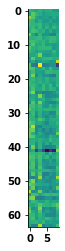

In [ ]:
plt.imshow(model.classifier.weight.detach().numpy().T)

In [ ]:
#@title
field_index = 0

@interact(field_index=widgets.IntSlider(value=0,min=0.,max=len(ds)-1),
          t_max=widgets.IntSlider(value=102,min=64.,max=102),
          softmax=False)
def plot_features(field_index, t_max, softmax=False):

  X,y,field_id = ds[field_index]

  X = torch.from_numpy(X).float()
  X = X[:t_max]

  batch = X.unsqueeze(0)

  scores = model(batch).squeeze()

  if softmax:
    scores = torch.softmax(scores, dim=-1)
  
  fig, axs = plt.subplots(1,2, figsize=(16,3))

  ax = axs[0]
  ax.plot(X)
  ax.set_xlabel("time [index]")
  ax.set_ylabel("input reflectance")
  ax.set_title("input time series (variable length)")
  ax.set_xlim(0,102)

  ax = axs[1]
  ax.barh(np.arange(scores.shape[0]), scores.detach().numpy())
  ax.set_yticks(np.arange(9))
  ax.set_yticklabels(ds.classname)
  ax.set_xlabel("class probability" if softmax else "logit value")
  ax.set_title("classifier output (logits)")

  if softmax:
    ax.set_xlim(0,1)

  plt.tight_layout()

interactive(children=(IntSlider(value=0, description='field_index', max=72), IntSlider(value=102, description=…

# 3 Optimization

Takeaway: We find parameters of of the neural network by minimizing a loss function

Here, we
* get an intuition of the loss function
* perform training on a training dataset
* test on a different test dataset


## Train/Test Split


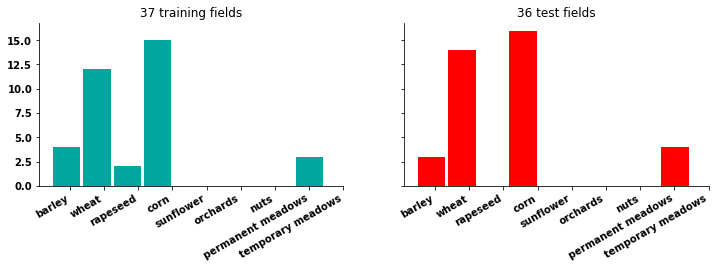

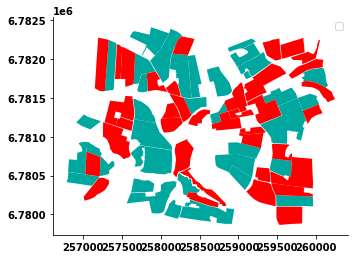

In [ ]:
from torch.utils.data import random_split

trainingcolor = "#00a79f"
testingcolor = "#ff0000"

n_train = (len(ds)//2) # split 50/50
trainds, testds = random_split(ds, [len(ds)-n_train,n_train], 
                              generator=torch.Generator().manual_seed(2)) # seed

fig, axs = plt.subplots(1,2, figsize=(12,3), sharey=True)

ax = axs[0]
ax.hist(torch.stack([y for X,y,field_id in testds]).numpy(), bins=9, width=0.8, color=trainingcolor)
ax.set_title(f"{len(trainds)} training fields")

ax = axs[1]
ax.hist(torch.stack([y for X,y,field_id in trainds]).numpy(), bins=9, width=0.8, color=testingcolor)
ax.set_title(f"{len(testds)} test fields")

for ax in axs:
  ax.set_xticks(ds.classes + 0.5)
  ax.set_xticklabels(ds.classname, rotation=30, ha="right")

fig, ax = plt.subplots(1,1)
field_parcels_geodataframe.set_index("id").loc[[field_id for X,y,field_id in testds]].plot(ax=ax, color=trainingcolor, label="training")
field_parcels_geodataframe.set_index("id").loc[[field_id for X,y,field_id in trainds]].plot(ax=ax, color=testingcolor, label="testing")
ax.legend(["training", "testing"])

## Evaluate the Model

In [ ]:

@torch.no_grad()
def evaluate(model, dataset):
  model.to(device)

  testdl = DataLoader(dataset, batch_size=5, drop_last=False)

  y_preds, y_scores, targets = [], [], []
  model.eval().to(device)
  with torch.no_grad():
    for idx, (X,y,fid) in enumerate(testdl):
      X = X.float().to(device)
      y_score = model(X)
      y_scores.append(y_score.cpu().detach().numpy())
      targets.append(y.detach().cpu().numpy())

  y_scores = np.vstack(y_scores)
  y_pred = y_scores.argmax(1)
  targets = np.hstack(targets)
  return y_scores, y_pred, targets

# initialize the model randomly again
model = Simple1DCNNModel(n_inputs=13,n_classes=9)

y_scores, y_pred, targets = evaluate(model, testds)

print("targets (ground truth):")
print(targets)
print("predictions:")
print(y_pred)
print()

accuracy = (targets==y_pred).mean()
print(f"accuracy: {accuracy:.2f}")


targets (ground truth):
[1 3 0 1 3 3 3 8 1 3 1 3 0 3 3 2 1 3 3 3 3 1 1 0 1 3 8 1 0 1 1 8 3 3 1 2]
predictions:
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]

accuracy: 0.00


## Stochastic Gradient Descent

<img src="https://i.ibb.co/kMtKHp3/ISPRS-Tutorial-Introduction-to-TSC.png" width=600px>


### Error metric: Cross Entropy Loss

#### Origins: [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy) between p and q distributions

$H(p,q) = - \sum_{x\in\mathcal{X}}$ p(x) log(q(x))

* p: ground truth distribution
* q: predicted distribution

this depends on the KL-divergence between p and q
$H(p,q) = H(p) + D_{KL}(p || q)$ which is
* small if p similar to q (low divergence) and 
* high if p dissimilar to q (high divergence)
---

#### Interpretation: Negative Log Likelihood


$\text{loss} = \sum_{(x,y) \in \mathcal{D}} - y \log(f(x))$

where **p is y (ground truth)** and **q is the prediction f(x)** and we **maximize the likelihood ([MLE estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation))** by minimizing the negative log likelihood.

--- 


often ground truth $y$ is encoded as one-hot vector: e.g. $[0,1,0]$. 

if we only consider sample i and the estimated probability of the correct class c, a very useful property arises:

$\text{loss}_i = -\log(f(x_{i})_c)$


In [ ]:
#@title
@interact(probability=widgets.FloatSlider(value=0.5,min=0.0,max=1., step=0.01))
def plot_loss(probability):
  y_pred = torch.log(torch.tensor([[probability + 1e-14]]))
  selected_loss = -y_pred

  fig, ax = plt.subplots(figsize=(12,4))
  logprob = torch.log(torch.tensor([[np.linspace(0,1, num=200) + 1e-3]]))
  loss = -logprob#criterion(logprob, torch.zeros(1,logprob.shape[2]).long()).squeeze()
  ax.plot(np.linspace(0,1, num=200), loss.squeeze())
  ax.scatter(probability, selected_loss, s=200)
  ax.text(probability+0.05, selected_loss+0.1, f"loss: {float(selected_loss):.2f}", ha="left")
  ax.set_xlabel("probability $f(x)_c$")
  ax.set_ylabel(r"$-\log(f(x))$")
  ax.set_title("Negative Log Likelihood Loss (aka Cross Entropy)")

interactive(children=(FloatSlider(value=0.5, description='probability', max=1.0, step=0.01), Output()), _dom_c…

## Model Training

In [ ]:
# start with one random model
model = Simple1DCNNModel(n_inputs=13,n_classes=9)

# loss/error criterion
criterion = torch.nn.CrossEntropyLoss(reduction="mean")


Iterative update of the model parameters to minimize a loss function

$w^\ast = \arg_w\min \sum Loss(f_w(X),y)$

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/sgd.png" width=600px>

In [ ]:
def train_single_epoch(model, optimizer, criterion, traindl):
  model.train().to(device)

  losses, correct = [], []
  for idx, (X,y,fid) in enumerate(traindl):
    optimizer.zero_grad()
    X = X.float().to(device)

    # prediction and loss
    y_pred = model(X)
    loss = criterion(y_pred, y.to(device))

    # update model weights
    loss.backward()
    optimizer.step()

    # statistics logging
    losses.append(loss.detach().cpu().numpy())
    correct.append(y_pred.argmax(1).detach().cpu().numpy() == y.detach().cpu().numpy())
  return np.stack(losses).mean(), np.stack(correct).mean()



In [ ]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import pandas as pd

num_epochs = 100

traindl = DataLoader(trainds, batch_size=5, drop_last=True)

model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)

stats = []
model.train()
with tqdm(range(num_epochs)) as progress_bar:
  for epoch in progress_bar:
    
    trainloss, trainaccuracy = train_single_epoch(model, optimizer, criterion, traindl)

    # evaluate the model on the test set
    y_scores, y_pred, targets = evaluate(model, testds)

    testloss = float(criterion( torch.from_numpy(y_scores), torch.from_numpy(targets)).detach().numpy())
    testaccuracy = (y_pred==targets).mean()

    # store
    stats.append({
        "trainloss":trainloss,
        "testloss":testloss,
        "trainaccuracy":trainaccuracy,
        "testaccuracy":testaccuracy,
        "epoch":epoch
    })
      
    progress_bar.set_description(f"Epoch: {epoch}: train loss {trainloss:.2f}, train accuracy={trainaccuracy*100:.0f}%, test loss {testloss:.2f}, test accuracy={testaccuracy*100:.0f}%")


stats = pd.DataFrame(stats).set_index("epoch")

  0%|          | 0/100 [00:00<?, ?it/s]

#### Training Curves

Text(400.3113636363635, 0.5, 'accuracy (higher is better)')

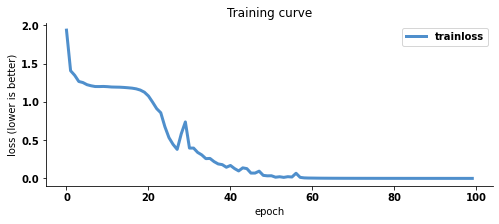

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

traincolor = "#4f8fcc"

stats.trainloss.plot(ax=ax, label="trainloss", color=traincolor, linewidth=3)
#stats.testloss.astype("float").plot(ax=ax, label="testloss", color=testcolor, linewidth=3)
ax.legend()
ax.set_title("Training curve")
ax.set_xlabel("epoch")
ax.set_ylabel("loss (lower is better)")

ax = axs[1]
stats.trainaccuracy.plot(ax=ax, label="training accuracy", color=traincolor, linewidth=3)
#stats.testaccuracy.astype("float").plot(ax=ax, label="test accuracy", color=testcolor, linewidth=3)
ax.legend()
ax.set_title("Training curve")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy (higher is better)")

### Feature Analysis

Lets return to **2 Deep Learning Model** and check the features

### Problem Overfitting

#### 100% accuracy. Problem Solved?

we minimized the term:

$w^\ast = \arg_w\min \sum Loss(f_w(X),y)$

we can rewrite the loss $Loss(w, D_{train})$ to emphasize the two components:
* model weights $w$ and
* dataset $D_{train} = \{x,y\}_{i=1}^N$

<img src="https://breizhcrops.s3.eu-central-1.amazonaws.com/isprstutorial2022/sgd_test.png" width=600px>

Text(0, 0.5, 'accuracy (higher is better)')

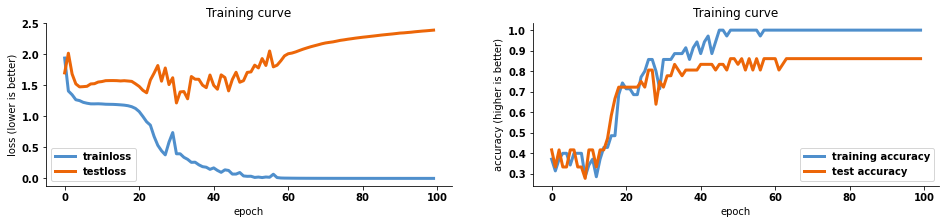

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(16,3))

traincolor = "#4f8fcc"
testcolor = "#ec6608"

ax = axs[0]
stats.trainloss.plot(ax=ax, label="trainloss", color=traincolor, linewidth=3)
stats.testloss.astype("float").plot(ax=ax, label="testloss", color=testcolor, linewidth=3)
ax.legend()
ax.set_title("Training curve")
ax.set_xlabel("epoch")
ax.set_ylabel("loss (lower is better)")

ax = axs[1]
stats.trainaccuracy.plot(ax=ax, label="training accuracy", color=traincolor, linewidth=3)
stats.testaccuracy.astype("float").plot(ax=ax, label="test accuracy", color=testcolor, linewidth=3)
ax.legend()
ax.set_title("Training curve")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy (higher is better)")

### Lets illustrate this with an numerical example

Steps:
1) We train a model again
2) record the train loss, test loss, and modelweights at each epoch
3) perform a PCA dimensionality reduction on the modelweights (maps 45897-dimensional weight vector to 2 PCA dimensions)

In [ ]:
epochs = 100

modelweights = []
stats = []

model = Simple1DCNNModel(n_inputs=13,n_classes=9).to(device)
optimizer = Adam(model.parameters(), lr=0.01)

model.train()
with tqdm(range(epochs)) as progress_bar:
  for epoch in progress_bar:
    trainloss, trainaccuracy = train_single_epoch(model, optimizer, criterion, traindl)
    y_scores, y_pred, targets = evaluate(model, testds)
    testloss = float(criterion( torch.from_numpy(y_scores), torch.from_numpy(targets)).detach().numpy())

    modelweights.append(torch.cat([p.reshape(-1) for p in model.parameters()]).cpu().detach().numpy())

    stats.append({
        "epoch":epoch,
        "trainloss":float(trainloss),
        "testloss":float(testloss)
    })  
    

stats = pd.DataFrame(stats)
modelweights = np.stack(modelweights)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from sklearn.decomposition import PCA
pca_features = PCA(n_components=2).fit_transform(modelweights)

print(f"PCA reduced {modelweights.shape} [epochs x weights] weights")
print(f"to {pca_features.shape} [epochs x 2] pca-features")

PCA reduced (100, 45897) [epochs x weights] weights
to (100, 2) [epochs x 2] pca-features


Lets recreate the training and "plot" the 2D PCA loss landscape

In [ ]:


@interact(epoch=widgets.IntSlider(min=0, max=len(stats), step=1, value=5), metricmode=["trainloss", "testloss"])
def plot(epoch, metricmode="trainloss"):
  i = epoch

  if metricmode == "trainloss":
    metric = stats.trainloss.values
  else:
    metric = stats.testloss.values

  fig, axs = plt.subplots(1,2, figsize=(12,3))


  ax = axs[0]

  if i>3:
    contours = ax.tricontour(pca_features[:i,0], pca_features[:i,1], metric[:i], levels=14, linewidths=0.5, colors='k')
    contoursf = ax.tricontourf(pca_features[:i,0], pca_features[:i,1], metric[:i], cmap="RdBu_r")
    cbar = fig.colorbar(contoursf)


  ax.scatter(pca_features[:i,0], pca_features[:i,1], c=metric[:i], s=200, cmap="RdBu_r", zorder=2)
  ax.plot(pca_features[:i,0], pca_features[:i,1], "-", linewidth=2,zorder=1)
  ax.set_xlabel("PCA-1 weight space")
  ax.set_ylabel("PCA-2 weight space")
  ax.set_xlim(pca_features[:,0].min(), pca_features[:,0].max())
  ax.set_ylim(pca_features[:,1].min(), pca_features[:,1].max())
  
  ax = axs[1]
  ax.plot(metric[:i])
  ax.set_xlabel("epoch")
  ax.set_xlim(0, stats.epoch.max())
  ax.set_ylabel("loss")
  ax.set_ylim(metric.min(), metric.max())
  

interactive(children=(IntSlider(value=5, description='epoch'), Dropdown(description='metricmode', options=('tr…

### How to tackle overfitting?

Open question (expand for solution)

* increase dataset size
* perform data augmentation
* change model configuration
* L2 regularization (weight-decay):

Suggestion 1: go back to Model Training and add `weight_decay=1e-3` to the optimizer

```
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
```

Suggestion 2:
Remove pooling layers from the model and re-train. Does it change the training and generalization?

```
Sequential(
  ...
  nn.Conv1d(13, feature_dimension, kernel_size=5, padding=5),
  nn.ReLU(),
  # nn.MaxPool1d(kernel_size=5), <- remove
  ...
  )
...
```

# 4 Transferability

We trained a small deep learning model on few data. Is the problem solved?

Problem: Deployment in-the-wild

## 4.1 Generalization-out-of-distribution

region Belle-Ile

In [ ]:
!pip -q install contextily
import contextily as cx

belleile = bzh.BreizhCrops("belle-ile")

import folium
import folium
from folium.features import DivIcon

field_parcels_geodataframe = ds.geodataframe()
belle_ile_field_parcels = belleile.geodataframe()


map = folium.Map(location=[47.9959, -2.90391], zoom_start=10)

def add_polygons(map, field_parcels_geodataframe, belle_ile_field_parcels):
  folium.GeoJson(data=field_parcels_geodataframe.to_crs(4326).to_json(),style_function=lambda x: {'fillColor': '#e41a1c', 'color': '#e41a1c'}).add_to(map)

  folium.GeoJson(data=belle_ile_field_parcels.to_crs(4326).to_json(),
                        style_function=lambda x: {'fillColor': '#ff7f00', 'color': '#ff7f00'}).add_to(map)

  # markers
  folium.map.Marker(
      [47.9959, -2.90391],
      icon=DivIcon(icon_size=(250,36),icon_anchor=(0,0),
                  html='<div style="font-size: 20pt">Kermaux</div>')
      ).add_to(map)

  folium.map.Marker(
      [47.311374, -3.019339],
      icon=DivIcon(icon_size=(250,36),icon_anchor=(0,0),
                  html='<div style="font-size: 20pt">Belle-Ile</div>')
      ).add_to(map)
      
add_polygons(map, field_parcels_geodataframe, belle_ile_field_parcels)

map

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


belle-ile.csv: 98.3kB [00:00, 143kB/s]                            


downloading breizhcrops_dataset/2017/L1C/belle-ile.h5.tar.gz


belle-ile.h5.tar.gz: 11.1MB [00:01, 7.73MB/s]                            


extracting breizhcrops_dataset/2017/L1C/belle-ile.h5.tar.gz to breizhcrops_dataset/2017/L1C/belle-ile.h5
removing breizhcrops_dataset/2017/L1C/belle-ile.h5.tar.gz
checking integrity by file size...
ok!


belle-ile.tar.gz: 254kB [00:00, 362kB/s]                            


Vegetation grows substantially different in belle-ile compared to kermaux.

We can see this in the label distribution

## 4.2 Test our model on Belle-Ile

targets (ground truth):
[7 7 7 ... 1 8 3]
predictions:
[1 1 1 ... 1 3 1]
                   precision    recall  f1-score   support

           barley       0.17      0.02      0.04        41
            wheat       0.02      0.65      0.04        20
         rapeseed       0.00      0.00      0.00         3
             corn       0.03      0.07      0.04        82
         orchards       0.00      0.00      0.00         2
permanent meadows       0.00      0.00      0.00       489
temporary meadows       0.39      0.20      0.26       412

         accuracy                           0.10      1049
        macro avg       0.09      0.13      0.05      1049
     weighted avg       0.16      0.10      0.11      1049



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


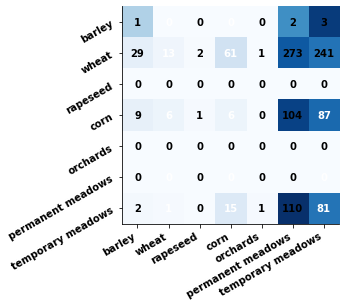

In [ ]:
testdl = DataLoader(belleile, batch_size=5, drop_last=False)

y_preds, targets = [], []
model.eval().to(device)
with torch.no_grad():
  for idx, (X,y,fid) in enumerate(testdl):
    X = X.float().to(device)
    y_preds.append(model(X).argmax(1).cpu().detach().numpy())
    targets.append(y.detach().cpu().numpy())

y_pred = np.hstack(y_preds)
targets = np.hstack(targets)

print("targets (ground truth):")
print(targets)
print("predictions:")
print(y_pred)


from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_pred=y_pred, y_true=targets, labels=np.unique(targets), target_names=belleile.classname[np.unique(targets)]))

cm = confusion_matrix(y_pred, targets, labels=np.unique(targets))
cm_norm = confusion_matrix(y_pred, targets, labels=np.unique(targets), normalize="true")
fig, ax = plt.subplots()
ax.imshow(cm_norm, cmap="Blues")
for i in np.arange(cm.shape[0]):
  for j in np.arange(cm.shape[1]):
    color = "black" if cm[i,j] < 5 else "white"
    ax.text(i,j,cm[j,i], va="center", ha="center", color=color)

ax.set_xticks(np.arange(len(np.unique(targets))))
ax.set_xticklabels(belleile.classname[np.unique(targets)], rotation=30, ha="right")

ax.set_yticks(np.arange(len(np.unique(targets))))
_ = ax.set_yticklabels(belleile.classname[np.unique(targets)], rotation=30, ha="right")

[Text(0, 0, 'barley'),
 Text(0, 0, 'corn'),
 Text(0, 0, 'rapeseed'),
 Text(0, 0, 'temporary meadows'),
 Text(0, 0, 'wheat')]

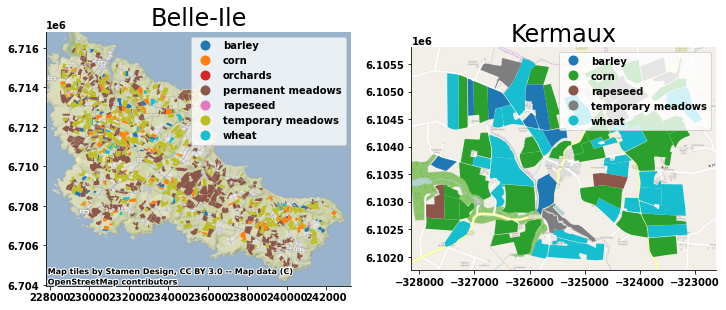

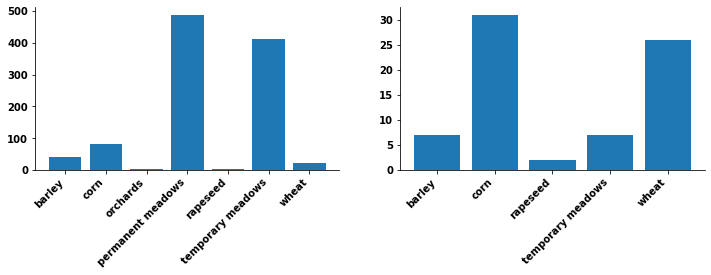

In [ ]:
#@title

fig, axs = plt.subplots(1,2,figsize=(12,6))

# top left
ax = axs[0]
belle_ile_field_parcels.plot(ax=ax, column="classname", legend=True)
cx.add_basemap(ax, crs=belle_ile_field_parcels.crs.to_string())
ax.set_title("Belle-Ile", fontsize=24)

# top right
ax = axs[1]
field_parcels_geodataframe.to_crs(3857).plot(ax=ax, column="classname", legend=True)
cx.add_basemap(ax, crs="EPSG:3857",zoom=15, source="https://{s}.tile.openstreetmap.fr/osmfr/{z}/{x}/{y}.png")
ax.set_title("Kermaux", fontsize=24)

fig, axs = plt.subplots(1,2,figsize=(12,3))

# bottom left
ax = axs[0]
names, counts = np.unique(belle_ile_field_parcels.classname, return_counts=True)
ax.bar(names, counts)
ax.set_xticklabels(names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# bottom right
ax = axs[1]
names, counts = np.unique(field_parcels_geodataframe.classname, return_counts=True)
ax.bar(names, counts)
ax.set_xticklabels(names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

## 4.3 Pre-trained Deep Learning Model

pre-trained with [this script](https://github.com/dl4sits/BreizhCrops/blob/master/examples/train.py) on 500k fields



### Training areas

In [ ]:
!wget -nc https://breizhcrops.s3.eu-central-1.amazonaws.com/nuts-3.zip
!unzip -n nuts-3.zip

training_areas = ["FR521", "FR522", "FR523"]

import geopandas as gpd
admin_boundaries = gpd.read_file("nuts-3.shp")
admin_boundaries = admin_boundaries.loc[admin_boundaries.NUTS_ID.isin(training_areas)]

--2022-06-05 10:29:04--  https://breizhcrops.s3.eu-central-1.amazonaws.com/nuts-3.zip
Resolving breizhcrops.s3.eu-central-1.amazonaws.com (breizhcrops.s3.eu-central-1.amazonaws.com)... 3.5.134.169
Connecting to breizhcrops.s3.eu-central-1.amazonaws.com (breizhcrops.s3.eu-central-1.amazonaws.com)|3.5.134.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23704 (23K) [application/zip]
Saving to: ‘nuts-3.zip’

nuts-3.zip          100%[===================>]  23.15K  --.-KB/s    in 0.1s    

2022-06-05 10:29:05 (232 KB/s) - ‘nuts-3.zip’ saved [23704/23704]

Archive:  nuts-3.zip
  inflating: nuts-3.cpg              
  inflating: nuts-3.dbf              
  inflating: nuts-3.prj              
  inflating: nuts-3.qmd              
  inflating: nuts-3.shp              
  inflating: nuts-3.shx              


In [ ]:
map = folium.Map(location=[47.9959, -2.90391], zoom_start=10)
add_polygons(map, field_parcels_geodataframe, belle_ile_field_parcels)

folium.GeoJson(data=admin_boundaries.to_crs(4326).to_json(),
                        style_function=lambda x: {'fillColor': '#ff7f00', 'color': '#ff7f0000'}).add_to(map)

# markers
folium.map.Marker(
    [48.435554, -2.945177],
    icon=DivIcon(icon_size=(250,36),icon_anchor=(0,0),
                html='<div style="font-size: 20pt">Training Areas</div>')
    ).add_to(map)

map

### Model download

In [ ]:

modelarchitecture = "Transformer" # try also "Transformer","TempCNN","LSTM"

model = bzh.models.pretrained(modelarchitecture).to(device)
model

TransformerEncoder_input-dim%3D13_num-classes%3D9_d-model%3D64_d-inner%3D128_n-layers%3D5_n-head%3D2_dropout%3D0.017998950510888446_learning-rate%3D0.00017369201853408445_weight-decay%3D3.5156458637523697e-06.pth: 705kB [00:01, 702kB/s]                            


TransformerModel(
  (inlinear): Linear(in_features=13, out_features=64, bias=True)
  (relu): ReLU()
  (transformerencoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.017998950510888446, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.017998950510888446, inplace=False)
        (dropout2): Dropout(p=0.017998950510888446, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_feat

### Prediction on Kermaux or Belle-Ile

In [ ]:
region = "kermaux" #" # change to "kermaux" to test there

testdl = DataLoader(bzh.BreizhCrops(region), batch_size=5, drop_last=False)

y_preds, targets = [], []
model.eval().to(device)
with torch.no_grad():
  for idx, (X,y,fid) in enumerate(testdl):
    X = X.float().to(device)
    y_preds.append(model(X).argmax(1).cpu().detach().numpy())
    targets.append(y.detach().cpu().numpy())

y_pred = np.hstack(y_preds)
targets = np.hstack(targets)


                   precision    recall  f1-score   support

           barley       1.00      0.86      0.92         7
            wheat       1.00      1.00      1.00        26
         rapeseed       1.00      1.00      1.00         2
             corn       0.97      1.00      0.98        31
temporary meadows       1.00      0.86      0.92         7

        micro avg       0.99      0.97      0.98        73
        macro avg       0.99      0.94      0.97        73
     weighted avg       0.99      0.97      0.98        73



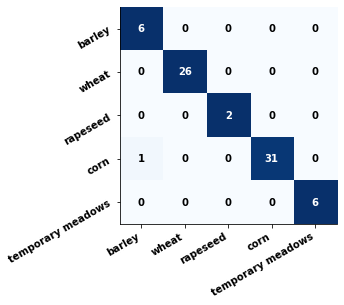

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_pred=y_pred, y_true=targets, labels=np.unique(targets), target_names=belleile.classname[np.unique(targets)]))

cm_norm = confusion_matrix(y_pred, targets, labels=np.unique(targets), normalize="true")
cm = confusion_matrix(y_pred, targets, labels=np.unique(targets))
fig, ax = plt.subplots()
ax.imshow(cm_norm, cmap="Blues")
for i in np.arange(cm.shape[0]):
  for j in np.arange(cm.shape[1]):
    color = "black" if cm_norm[i,j] < 0.5 else "white"
    ax.text(i,j,cm[j,i], va="center", ha="center", color=color)
ax.set_xticks(np.arange(len(np.unique(targets))))
ax.set_xticklabels(belleile.classname[np.unique(targets)], rotation=30, ha="right")

ax.set_yticks(np.arange(len(np.unique(targets))))
_ = ax.set_yticklabels(belleile.classname[np.unique(targets)], rotation=30, ha="right")